In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('..')

In [2]:
import networkx as nx
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from nn_homology import nn_graph

import persim # see persim.scikit-tda.org
from ripser import ripser # see ripser.scikit-tda.org

To generate the model used in this example, I ran:

`python main.py --arch_type lenet5_nmp --dataset cifar10 --prune_percent 90 --prune_iterations 2 --end_iter 50`

In [3]:
# Global-like variable definitions.
model_name = 'lenet5_nmp'
dataset_name = 'cifar10'
data_location = '../data' # location of training data (MNIST, FashionMNIST, CIFAR, etc.)
msk_pct = 90 # prune percentage for LT network
model_loc0 = 'saves/{}/{}/0_model_lt.pth.tar'.format(model_name, dataset_name) # location of saved, un-pruned model 
model_loc1 = 'saves/{}/{}/1_model_lt.pth.tar'.format(model_name, dataset_name) # location of saved, pruned model (after 1 prune iteration)

## Unpruned Model Homology

In [4]:
# load the model.
model = torch.load(model_loc0)

/home/schraterlab/anaconda3/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'archs.cifar10.LeNet5.LeNet5_nmp' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [5]:
param_info = [{'layer_type': 'Conv2d', 'kernel_size':(5,5), 'stride':1, 'padding': 0, 'name':'Conv1'},
                {'layer_type': 'Conv2d', 'kernel_size':(5,5), 'stride':1, 'padding':0, 'name':'Conv2'},
                {'layer_type':'Linear', 'name': 'Linear1'},
                {'layer_type':'Linear', 'name': 'Linear2'},
                {'layer_type':'Linear', 'name': 'Linear3'}]

In [6]:
NNG = nn_graph.NNGraph()
NNG.parameter_graph(model, param_info, (1,3,32,32))

Layer: Conv1
Layer: Conv2
Layer: Linear1
Layer: Linear2
Layer: Linear3


In [7]:
# helper function for testing model, outputs accuracy
def test(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

In [8]:
# Test to make sure model works.
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
testdataset = datasets.CIFAR10(data_location, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=32, shuffle=False, num_workers=0,drop_last=True)
criterion = torch.nn.CrossEntropyLoss()
print('Accuracy: {}'.format(test(model, test_loader, criterion)))

Accuracy: 49.85


In [13]:
# compute rips persistent homology (up to 1st dimension) over entire network 
# using (sparse) adjacency matrix as distance matrix.
%time rips = ripser(scipy.sparse.csr_matrix(NNG.get_adjacency()), distance_matrix=True, maxdim=1)
rips

CPU times: user 1min 23s, sys: 990 ms, total: 1min 24s
Wall time: 1min 24s


{'dgms': [array([[0.        , 0.31368825],
         [0.        , 0.31368825],
         [0.        , 0.31368825],
         ...,
         [0.        , 1.        ],
         [0.        , 1.        ],
         [0.        ,        inf]]),
  array([[1.00888455,        inf],
         [1.0083518 ,        inf],
         [1.0082556 ,        inf],
         ...,
         [0.32957819,        inf],
         [0.32957819,        inf],
         [0.32957819,        inf]])],
 'cocycles': [[], []],
 'num_edges': 2852040,
 'dperm2all': <20086x20086 sparse matrix of type '<class 'numpy.float64'>'
 	with 5704080 stored elements in Compressed Sparse Row format>,
 'idx_perm': array([    0,     1,     2, ..., 20083, 20084, 20085]),
 'r_cover': 0.0}

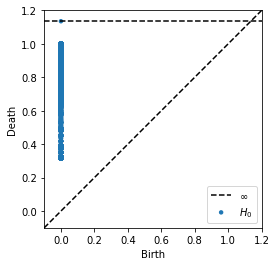

In [14]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips['dgms'][0])

## Pruned LT Homology

In [15]:
# load the LT model.
model_lt = torch.load(model_loc1)

/home/schraterlab/anaconda3/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'archs.cifar10.LeNet5.LeNet5_nmp' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [16]:
# test this model's accuracy.
print('Accuracy: {}'.format(test(model_lt, test_loader, criterion)))

Accuracy: 38.39


In [17]:
NNG.update_adjacency(model_lt)

In [18]:
# compute rips persistent homology (up to 1st dimension) over entire network 
# using (sparse) adjacency matrix as distance matrix.
%time rips_lt = ripser(scipy.sparse.csr_matrix(NNG.get_adjacency()), distance_matrix=True, maxdim=1)
rips_lt

CPU times: user 1min 23s, sys: 908 ms, total: 1min 24s
Wall time: 1min 24s


{'dgms': [array([[0.        , 0.35624263],
         [0.        , 0.35624263],
         [0.        , 0.35624263],
         ...,
         [0.        , 1.        ],
         [0.        , 1.        ],
         [0.        ,        inf]]),
  array([[1.00761032,        inf],
         [1.00601745,        inf],
         [1.00592864,        inf],
         ...,
         [0.39180687,        inf],
         [0.39180687,        inf],
         [0.39180687,        inf]])],
 'cocycles': [[], []],
 'num_edges': 2852040,
 'dperm2all': <20086x20086 sparse matrix of type '<class 'numpy.float64'>'
 	with 5704080 stored elements in Compressed Sparse Row format>,
 'idx_perm': array([    0,     1,     2, ..., 20083, 20084, 20085]),
 'r_cover': 0.0}

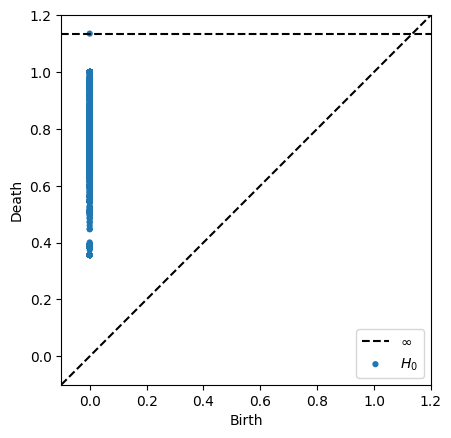

In [19]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips_lt['dgms'][0])

## Compare Networks

In [20]:
# compute the bottleneck distance between networks and plot the implicit matching. 
# bottleneck distance is defined as the distance between the farthest-apart matched points. 
# NOTE: the persim package ignores points at infinity, so this calculation still returns 
# a bounded result. Technically, the bottleneck distance between the two networks is \infty. 
distance_bottleneck, (matching, D) = persim.bottleneck(rips['dgms'][0], rips_lt['dgms'][0], matching=True)
persim.bottleneck_matching(rips['dgms'][0], rips_lt['dgms'][0], matching, D, labels=['FC $H_0$', 'LT $H_0$'])
print('Bottleneck Distance: {}'.format(distance_bottleneck))

/home/schraterlab/anaconda3/lib/python3.8/site-packages/persim/bottleneck.py:53: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/home/schraterlab/anaconda3/lib/python3.8/site-packages/persim/bottleneck.py:63: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


KeyboardInterrupt: 